#### 내거랑 원본이랑 비교

In [1]:
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt
import AEC_speex as aec

In [2]:
temp, sr = sf.read("../data/Vaccum/input.wav")
mic = temp[:, 0]
ref = temp[:, 2]

aec_speech, aec_echo = aec.run_AEC(ref, mic, sr, processor=aec.MDF,
                                   output_filename="Linear_AEC_vaccum"
                                   )
erle = aec.calculate_erle(mic, aec_echo, opt_print=True)
erle

CALCULATING ERLE FOR 'real' DATA ... 

1.5394695360832997

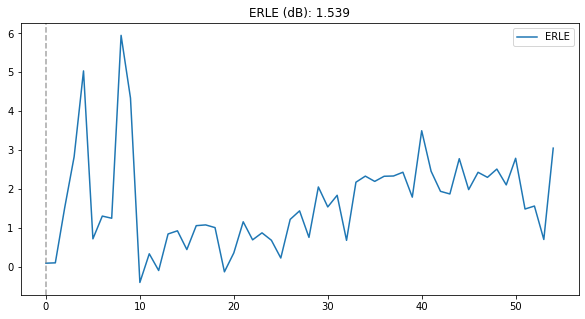

In [3]:
# ERLE graph

win_erle_1 = aec.windowed_calculate_erle(mic, aec_echo)

plt.figure(figsize=(10, 5))
plt.plot(win_erle_1, label="ERLE")
plt.legend()

spacing = int(len(mic)/1024)  # 간격
for xc in range(0, len(win_erle_1), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)
    
plt.title(f"ERLE (dB): {erle:.3f}")
plt.show()

In [10]:
temp, sr = sf.read("../data/Vaccum/input.wav")
scaler = np.std(temp[:, 0]) / np.std(temp[:, 2])
mic = temp[:, 0] 
ref = temp[:, 2] * scaler

aec_speech, aec_echo = aec.run_AEC(ref, mic, sr, processor=aec.MDF,
                                #    output_filename="Linear_AEC_vaccum"
                                   )
erle = aec.calculate_erle(mic, aec_echo, opt_print=True)
erle

CALCULATING ERLE FOR 'real' DATA ... 

1.568049052253047

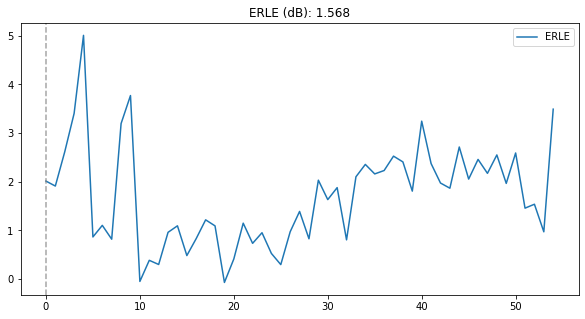

In [11]:
# ERLE graph

win_erle_1 = aec.windowed_calculate_erle(mic, aec_echo)

plt.figure(figsize=(10, 5))
plt.plot(win_erle_1, label="ERLE")
plt.legend()

spacing = int(len(mic)/1024)  # 간격
for xc in range(0, len(win_erle_1), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)
    
plt.title(f"ERLE (dB): {erle:.3f}")
plt.show()

In [12]:
mic, sr = sf.read("../data/Mixing/RIR_mixed.wav")
ref, sr = sf.read("../data/Mixing/RIR_echo.wav")
gt_ref, sr = sf.read("../data/Mixing/echo.wav")

mic = mic[:, 0]
ref = ref[:, 0]
gt_ref = gt_ref/np.max(gt_ref)

In [13]:
aec_speech, aec_echo = aec.run_AEC(gt_ref, mic, sr, processor=aec.MDF,
                                   output_filename="Linear_AEC_dynamiteRIR"
                                   )
aec.calculate_erle(ref, aec_echo, tag='simulation', opt_print=True)

CALCULATING ERLE FOR 'simulation' DATA ... 

13.809843086491494

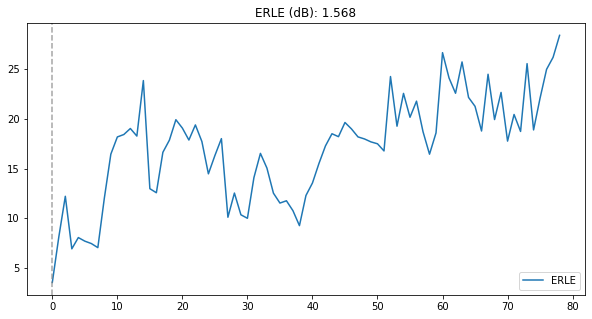

In [14]:
# ERLE graph

win_erle_1 = aec.windowed_calculate_erle(ref, aec_echo, tag='simulation')

plt.figure(figsize=(10, 5))
plt.plot(win_erle_1, label="ERLE")
plt.legend()

spacing = int(len(mic)/1024)  # 간격
for xc in range(0, len(win_erle_1), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)
    
plt.title(f"ERLE (dB): {erle:.3f}")
plt.show()